In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

# CIFAR-10-C
dataset_dir = '/kaggle/input/cifar-c'
print(os.listdir(dataset_dir))
# Define the path to the subdirectory
sub_dir = os.path.join(dataset_dir, 'CIFAR-10-C')
# List contents of the subdirectory
print(os.listdir(sub_dir))

# CIFAR-100-C
# dataset_dir = '/kaggle/input/cifar-100-c'
# print(os.listdir(dataset_dir))

['CIFAR-10-C']
['motion_blur.npy', 'speckle_noise.npy', 'jpeg_compression.npy', 'impulse_noise.npy', 'defocus_blur.npy', 'brightness.npy', 'elastic_transform.npy', 'snow.npy', 'labels.npy', 'gaussian_blur.npy', 'frost.npy', 'zoom_blur.npy', 'spatter.npy', 'fog.npy', 'gaussian_noise.npy', 'contrast.npy', 'saturate.npy', 'shot_noise.npy', 'pixelate.npy', 'glass_blur.npy']


In [2]:
!pip install torchmetrics
!git clone https://github.com/EkagraGupta/MasterArbeit.git

     ━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━ 542.7/866.2 kB 16.5 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 15.0 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


Cloning into 'MasterArbeit'...


remote: Enumerating objects: 1794, done.


remote: Counting objects: 100% (410/410), done.


remote: Compressing objects: 100% (273/273), done.


remote: Total 1794 (delta 157), reused 387 (delta 137), pack-reused 1384 (from 1)
Receiving objects: 100% (1794/1794), 621.94 MiB | 28.70 MiB/s, done.
Resolving deltas: 100% (820/820), done.


Updating files: 100% (169/169), done.


In [3]:
# Import statements
import torch
import random
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision.transforms import TrivialAugmentWide
from torch.utils.data import Dataset
from torch.utils.data import ConcatDataset
import os

# Define the device
tpu = True

if tpu == True:
    import torch_xla
    import torch_xla.core.xla_model as xm
    device = xm.xla_device()
else:
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')  #intend here for else


class CustomDataset(Dataset):
    def __init__(self, np_images, original_dataset, resize):
        # Load images
        self.images = torch.from_numpy(np_images).permute(0, 3, 1, 2) / 255
         #Normalize the images
        #transform_test = transforms.Compose([
            #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        #])
        #self.images = transform_test(self.images)
        #if resize == True:
            #self.images = transforms.Resize(224, antialias=True)(self.images)
        
        # Extract labels from the original PyTorch dataset
        self.labels = [label for _, label in original_dataset]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        # Get image and label for the given index
        image = self.images[index]
        label = self.labels[index]

        return image, label

# Define the function to load corrupted datasets separately
def load_data_c_separately(dataset, testset, resize, test_transforms, batch_size):
    corruptions = ['gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur', 'glass_blur', 'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog', 'brightness', 'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression', 'speckle_noise', 'gaussian_blur', 'spatter', 'saturate']
    np.asarray(corruptions)
    c_datasets = {}
    for corruption in corruptions:
        if dataset == 'CIFAR10':
            np_data_c = np.load(f'/kaggle/input/cifar-c/CIFAR-10-C/{corruption}.npy')
            np_data_c = np.array(np.array_split(np_data_c, 5))
            custom_dataset = CustomDataset(np_data_c[0], testset, resize)  # Load only one split for now
            custom_dataloader = torch.utils.data.DataLoader(custom_dataset, batch_size=batch_size, shuffle=False)
            c_datasets[corruption] = custom_dataloader
        else:
            print('No corrupted benchmark available other than CIFAR10-c.')

    return c_datasets


# Load corrupted datasets
#corrupted_datasets = load_data_c(dataset='CIFAR10', testset=testset, resize=True, 
                                 #test_transforms=None, subset=False, subsetsize=None)

# Transformations for training and test sets
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),  
    TrivialAugmentWide(),
    transforms.ToTensor(),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
])

batch_size = 512

# Use CIFAR-10 dataset for training
num_classes = 10    # CIFAR-10
baseline_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
baseline_trainloader = torch.utils.data.DataLoader(baseline_trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2, pin_memory=True)

# Use CIFAR-10 dataset for testing
baseline_testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
baseline_testloader = torch.utils.data.DataLoader(baseline_testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2, pin_memory=True)

# # Use CIFAR-100 dataset for training
# num_classes = 100   # CIFAR-100
# baseline_trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
#                                         download=True, transform=transform_train)
# baseline_trainloader = torch.utils.data.DataLoader(baseline_trainset, batch_size=batch_size,
#                                           shuffle=True, num_workers=2, pin_memory=True)

# # Use CIFAR-100 dataset for testing
# baseline_testset = torchvision.datasets.CIFAR100(root='./data', train=False,
#                                        download=True, transform=transform_test)
# baseline_testloader = torch.utils.data.DataLoader(baseline_testset, batch_size=batch_size,
#                                          shuffle=False, num_workers=2, pin_memory=True)

%cd /kaggle/working/MasterArbeit
from augment_dataset import create_transforms, load_data
from compute_loss import soft_loss

"""
 Create the transformations based on the provided flags:
 - If all flags (random_cropping, aggressive_augmentation, and custom) are False:
   No augmentation other than default preprocessing is applied.
 - If random_cropping (rc) is True and the others (aa and custom) are False:
   Only random cropping is applied.
 - If random_cropping (rc) and aggressive_augmentation (aa) are True, and custom is False:
   Random cropping and conventional aggressive augmentation techniques (TA) are applied.
 - If all three flags (rc, aa, custom) are True:
   Random cropping and soft augmentation techniques (TA) are applied.
 - If random_cropping (rc) is False, aggressive_augmentation (aa) is True, and custom is False:
   Only conventional aggressive augmentation techniques (TA) are applied (no soft labels).
 - If random_cropping (rc) is False, aggressive_augmentation (aa) is True, and custom is True:
   Aggressive augmentation (TA) is applied with soft labeling.
"""

transforms_preprocess, transforms_augmentation = create_transforms(random_cropping=False, aggressive_augmentation=True, custom=True)
custom_trainset, custom_testset = load_data(transforms_preprocess=transforms_preprocess, transforms_augmentation=transforms_augmentation)
custom_trainloader = torch.utils.data.DataLoader(custom_trainset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
custom_testloader = torch.utils.data.DataLoader(custom_testset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
%cd

classes = baseline_trainset.classes


/usr/local/lib/python3.10/site-packages/torch_xla/__init__.py:202: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(


E0000 00:00:1725194882.334367      77 common_lib.cc:818] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:483


  0%|          | 0/170498071 [00:00<?, ?it/s]

  0%|          | 65536/170498071 [00:00<07:49, 362926.39it/s]

  0%|          | 229376/170498071 [00:00<04:11, 676878.14it/s]

  1%|          | 917504/170498071 [00:00<01:21, 2085690.85it/s]

  2%|▏         | 2785280/170498071 [00:00<00:26, 6447155.46it/s]

  3%|▎         | 5570560/170498071 [00:00<00:13, 12289887.51it/s]

  5%|▌         | 9306112/170498071 [00:00<00:08, 19307259.94it/s]

  8%|▊         | 12976128/170498071 [00:00<00:06, 24280308.72it/s]

  9%|▉         | 16154624/170498071 [00:01<00:06, 22976973.32it/s]

 12%|█▏        | 20054016/170498071 [00:01<00:05, 27209981.86it/s]

 14%|█▎        | 23330816/170498071 [00:01<00:05, 28643167.86it/s]

 16%|█▌        | 26509312/170498071 [00:01<00:04, 29345319.02it/s]

 18%|█▊        | 29851648/170498071 [00:01<00:04, 30488392.28it/s]

 20%|█▉        | 33554432/170498071 [00:01<00:04, 32362992.47it/s]

 22%|██▏       | 37224448/170498071 [00:01<00:03, 33619660.18it/s]

 24%|██▍       | 40927232/170498071 [00:01<00:03, 34607479.40it/s]

 26%|██▌       | 44433408/170498071 [00:01<00:03, 32001342.67it/s]

 28%|██▊       | 48136192/170498071 [00:02<00:03, 33126942.21it/s]

 30%|███       | 51511296/170498071 [00:02<00:03, 30955175.20it/s]

 32%|███▏      | 54853632/170498071 [00:02<00:03, 31621409.47it/s]

 34%|███▍      | 58130432/170498071 [00:02<00:03, 31935560.61it/s]

 36%|███▋      | 61833216/170498071 [00:02<00:03, 33388188.80it/s]

 38%|███▊      | 65536000/170498071 [00:02<00:03, 33849378.44it/s]

 40%|████      | 68943872/170498071 [00:02<00:03, 32903059.03it/s]

 42%|████▏     | 72286208/170498071 [00:02<00:02, 32931444.55it/s]

 44%|████▍     | 75595776/170498071 [00:02<00:02, 32953215.77it/s]

 46%|████▋     | 79265792/170498071 [00:02<00:02, 34036058.03it/s]

 49%|████▊     | 82706432/170498071 [00:03<00:03, 26146899.76it/s]

 50%|█████     | 85884928/170498071 [00:03<00:03, 27503229.64it/s]

 52%|█████▏    | 89456640/170498071 [00:03<00:02, 29605872.85it/s]

 55%|█████▍    | 92995584/170498071 [00:03<00:02, 31160309.96it/s]

 57%|█████▋    | 96534528/170498071 [00:03<00:02, 32312863.78it/s]

 59%|█████▊    | 100073472/170498071 [00:03<00:02, 33161065.93it/s]

 61%|██████    | 103677952/170498071 [00:03<00:01, 33965096.83it/s]

 63%|██████▎   | 107151360/170498071 [00:03<00:02, 29040650.16it/s]

 65%|██████▍   | 110428160/170498071 [00:04<00:02, 29931756.20it/s]

 67%|██████▋   | 114032640/170498071 [00:04<00:01, 31566312.40it/s]

 69%|██████▉   | 117473280/170498071 [00:04<00:01, 32354510.56it/s]

 71%|███████   | 121044992/170498071 [00:04<00:01, 33293017.97it/s]

 73%|███████▎  | 124583936/170498071 [00:04<00:01, 33882008.63it/s]

 75%|███████▌  | 128155648/170498071 [00:04<00:01, 34411869.91it/s]

 77%|███████▋  | 131727360/170498071 [00:04<00:01, 34763220.79it/s]

 79%|███████▉  | 135233536/170498071 [00:04<00:01, 32054992.84it/s]

 81%|████████  | 138510336/170498071 [00:04<00:00, 32079443.59it/s]

 83%|████████▎ | 141787136/170498071 [00:04<00:00, 31393780.47it/s]

 85%|████████▌ | 145063936/170498071 [00:05<00:00, 31723963.75it/s]

 87%|████████▋ | 148275200/170498071 [00:05<00:00, 31335057.90it/s]

 89%|████████▉ | 151552000/170498071 [00:05<00:00, 31631514.09it/s]

 91%|█████████ | 154796032/170498071 [00:05<00:00, 31808108.13it/s]

 93%|█████████▎| 158400512/170498071 [00:05<00:00, 33026161.36it/s]

 95%|█████████▍| 161939456/170498071 [00:05<00:00, 33705111.34it/s]

 97%|█████████▋| 165412864/170498071 [00:05<00:00, 33974619.40it/s]

 99%|█████████▉| 168984576/170498071 [00:05<00:00, 34465128.60it/s]

100%|██████████| 170498071/170498071 [00:05<00:00, 29019318.38it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


Files already downloaded and verified


/usr/local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/kaggle/working/MasterArbeit


/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


  0%|          | 0/170498071 [00:00<?, ?it/s]

  0%|          | 32768/170498071 [00:00<15:50, 179317.71it/s]

  0%|          | 196608/170498071 [00:00<03:27, 819296.65it/s]

  0%|          | 360448/170498071 [00:00<02:32, 1117792.24it/s]

  1%|          | 884736/170498071 [00:00<01:22, 2051450.77it/s]

  1%|▏         | 2228224/170498071 [00:00<00:31, 5308855.80it/s]

  2%|▏         | 4063232/170498071 [00:00<00:18, 9074111.21it/s]

  4%|▍         | 7307264/170498071 [00:00<00:10, 15815252.95it/s]

  6%|▋         | 10813440/170498071 [00:00<00:07, 21453752.74it/s]

  8%|▊         | 13893632/170498071 [00:01<00:06, 24174088.51it/s]

 10%|█         | 17399808/170498071 [00:01<00:05, 27387668.76it/s]

 12%|█▏        | 20709376/170498071 [00:01<00:05, 29080470.66it/s]

 14%|█▍        | 23756800/170498071 [00:01<00:04, 29491404.94it/s]

 16%|█▌        | 27557888/170498071 [00:01<00:04, 31996179.15it/s]

 18%|█▊        | 30801920/170498071 [00:01<00:04, 30871864.53it/s]

 20%|█▉        | 34045952/170498071 [00:01<00:04, 31159243.82it/s]

 22%|██▏       | 37421056/170498071 [00:01<00:04, 31896481.24it/s]

 24%|██▍       | 40992768/170498071 [00:01<00:03, 33014664.41it/s]

 26%|██▌       | 44564480/170498071 [00:01<00:03, 33733702.37it/s]

 28%|██▊       | 47972352/170498071 [00:02<00:04, 30383942.90it/s]

 30%|███       | 51380224/170498071 [00:02<00:03, 31275251.84it/s]

 32%|███▏      | 54657024/170498071 [00:02<00:03, 31618497.86it/s]

 34%|███▍      | 57966592/170498071 [00:02<00:03, 32001118.98it/s]

 36%|███▌      | 61571072/170498071 [00:02<00:03, 33168526.13it/s]

 38%|███▊      | 65142784/170498071 [00:02<00:03, 33889760.96it/s]

 40%|████      | 68648960/170498071 [00:02<00:02, 34212625.63it/s]

 42%|████▏     | 72089600/170498071 [00:02<00:02, 33705553.82it/s]

 44%|████▍     | 75497472/170498071 [00:02<00:02, 33055154.38it/s]

 46%|████▋     | 79069184/170498071 [00:03<00:02, 33821142.89it/s]

 48%|████▊     | 82477056/170498071 [00:03<00:02, 32927319.37it/s]

 50%|█████     | 85786624/170498071 [00:03<00:02, 32564005.75it/s]

 52%|█████▏    | 89161728/170498071 [00:03<00:02, 32893205.33it/s]

 54%|█████▍    | 92471296/170498071 [00:03<00:02, 29915999.83it/s]

 56%|█████▌    | 95846400/170498071 [00:03<00:02, 30961442.36it/s]

 58%|█████▊    | 99483648/170498071 [00:03<00:02, 32467661.90it/s]

 60%|██████    | 102793216/170498071 [00:03<00:02, 32293424.72it/s]

 62%|██████▏   | 106528768/170498071 [00:03<00:01, 33303011.45it/s]

 64%|██████▍   | 109903872/170498071 [00:04<00:01, 32035003.90it/s]

 66%|██████▋   | 113180672/170498071 [00:04<00:01, 32175247.63it/s]

 68%|██████▊   | 116424704/170498071 [00:04<00:01, 32104916.53it/s]

 70%|███████   | 119668736/170498071 [00:04<00:01, 31961456.58it/s]

 72%|███████▏  | 122945536/170498071 [00:04<00:01, 32178642.69it/s]

 74%|███████▍  | 126353408/170498071 [00:04<00:01, 32633231.32it/s]

 76%|███████▌  | 129630208/170498071 [00:04<00:01, 32449725.07it/s]

 78%|███████▊  | 132907008/170498071 [00:04<00:01, 29527390.57it/s]

 80%|████████  | 136544256/170498071 [00:04<00:01, 31405797.34it/s]

 82%|████████▏ | 140050432/170498071 [00:04<00:00, 32420811.04it/s]

 84%|████████▍ | 143360000/170498071 [00:05<00:00, 32379058.72it/s]

 86%|████████▌ | 146767872/170498071 [00:05<00:00, 31498457.89it/s]

 88%|████████▊ | 149946368/170498071 [00:05<00:00, 31317590.76it/s]

 90%|████████▉ | 153124864/170498071 [00:05<00:00, 31296774.20it/s]

 92%|█████████▏| 156270592/170498071 [00:05<00:00, 31092808.98it/s]

 94%|█████████▎| 159416320/170498071 [00:05<00:00, 30740425.60it/s]

 95%|█████████▌| 162496512/170498071 [00:05<00:00, 30683887.05it/s]

 97%|█████████▋| 165576704/170498071 [00:05<00:00, 30508214.94it/s]

 99%|█████████▉| 168656896/170498071 [00:05<00:00, 30521598.89it/s]

100%|██████████| 170498071/170498071 [00:05<00:00, 28638385.82it/s]

Extracting ./data/train/cifar-10-python.tar.gz to ./data/train


  0%|          | 0/170498071 [00:00<?, ?it/s]

  0%|          | 65536/170498071 [00:00<07:59, 355611.27it/s]

  0%|          | 229376/170498071 [00:00<04:18, 659235.41it/s]

  0%|          | 524288/170498071 [00:00<02:04, 1365986.92it/s]

  1%|          | 1114112/170498071 [00:00<01:01, 2750623.02it/s]

  1%|▏         | 2326528/170498071 [00:00<00:30, 5592436.63it/s]

  2%|▏         | 4194304/170498071 [00:00<00:17, 9498074.50it/s]

  4%|▎         | 6193152/170498071 [00:00<00:13, 12620881.99it/s]

  5%|▍         | 8323072/170498071 [00:00<00:10, 15179013.51it/s]

  6%|▌         | 10518528/170498071 [00:01<00:09, 17181672.01it/s]

  8%|▊         | 12910592/170498071 [00:01<00:08, 19106036.30it/s]

  9%|▉         | 15335424/170498071 [00:01<00:07, 20622320.37it/s]

 10%|█         | 17858560/170498071 [00:01<00:06, 21945941.76it/s]

 12%|█▏        | 20545536/170498071 [00:01<00:06, 23312291.67it/s]

 14%|█▎        | 23363584/170498071 [00:01<00:05, 24671241.58it/s]

 15%|█▌        | 26181632/170498071 [00:01<00:05, 25690732.82it/s]

 17%|█▋        | 29097984/170498071 [00:01<00:05, 26648701.58it/s]

 19%|█▉        | 32047104/170498071 [00:01<00:05, 27380177.56it/s]

 21%|██        | 34996224/170498071 [00:01<00:04, 27975298.47it/s]

 22%|██▏       | 37945344/170498071 [00:02<00:04, 28287634.90it/s]

 24%|██▍       | 40796160/170498071 [00:02<00:05, 25300711.35it/s]

 26%|██▌       | 43548672/170498071 [00:02<00:04, 25904867.61it/s]

 27%|██▋       | 46301184/170498071 [00:02<00:05, 21824328.87it/s]

 29%|██▉       | 49152000/170498071 [00:02<00:05, 23483736.88it/s]

 31%|███       | 52002816/170498071 [00:02<00:04, 24764196.57it/s]

 32%|███▏      | 54886400/170498071 [00:02<00:04, 25865296.07it/s]

 34%|███▍      | 57573376/170498071 [00:02<00:05, 22025102.56it/s]

 36%|███▌      | 60555264/170498071 [00:03<00:04, 23977265.54it/s]

 37%|███▋      | 63504384/170498071 [00:03<00:04, 25427458.22it/s]

 39%|███▉      | 66453504/170498071 [00:03<00:03, 26486309.51it/s]

 41%|████      | 69206016/170498071 [00:03<00:04, 22587175.42it/s]

 42%|████▏     | 72220672/170498071 [00:03<00:04, 24490641.76it/s]

 44%|████▍     | 75333632/170498071 [00:03<00:03, 26245236.47it/s]

 46%|████▌     | 78381056/170498071 [00:03<00:03, 27390457.23it/s]

 48%|████▊     | 81231872/170498071 [00:03<00:03, 23397134.48it/s]

 49%|████▉     | 84344832/170498071 [00:04<00:03, 25347398.91it/s]

 51%|█████▏    | 87490560/170498071 [00:04<00:03, 26957950.60it/s]

 53%|█████▎    | 90636288/170498071 [00:04<00:02, 28189225.07it/s]

 55%|█████▍    | 93585408/170498071 [00:04<00:03, 24187427.55it/s]

 57%|█████▋    | 96698368/170498071 [00:04<00:02, 25949616.80it/s]

 59%|█████▊    | 99909632/170498071 [00:04<00:02, 27573364.50it/s]

 60%|██████    | 103120896/170498071 [00:04<00:02, 28810640.02it/s]

 62%|██████▏   | 106233856/170498071 [00:04<00:02, 25050095.28it/s]

 64%|██████▍   | 109248512/170498071 [00:04<00:02, 26347281.63it/s]

 66%|██████▌   | 112558080/170498071 [00:05<00:02, 28141279.02it/s]

 68%|██████▊   | 115900416/170498071 [00:05<00:01, 29579499.72it/s]

 70%|██████▉   | 119209984/170498071 [00:05<00:01, 30529370.73it/s]

 72%|███████▏  | 122355712/170498071 [00:05<00:01, 26000270.42it/s]

 74%|███████▍  | 125796352/170498071 [00:05<00:01, 28144892.86it/s]

 76%|███████▌  | 129204224/170498071 [00:05<00:01, 29697992.90it/s]

 78%|███████▊  | 132612096/170498071 [00:05<00:01, 30879113.81it/s]

 80%|███████▉  | 135823360/170498071 [00:05<00:01, 26406913.30it/s]

 82%|████████▏ | 139231232/170498071 [00:05<00:01, 28336307.47it/s]

 84%|████████▎ | 142704640/170498071 [00:06<00:00, 30027774.73it/s]

 86%|████████▌ | 146210816/170498071 [00:06<00:00, 31410679.03it/s]

 88%|████████▊ | 149454848/170498071 [00:06<00:00, 26949953.91it/s]

 90%|████████▉ | 152731648/170498071 [00:06<00:00, 28418682.55it/s]

 92%|█████████▏| 156172288/170498071 [00:06<00:00, 29995782.37it/s]

 94%|█████████▎| 159645696/170498071 [00:06<00:00, 31286047.57it/s]

 96%|█████████▌| 163184640/170498071 [00:06<00:00, 32434818.24it/s]

 98%|█████████▊| 166526976/170498071 [00:06<00:00, 27657373.57it/s]

100%|█████████▉| 170000384/170498071 [00:06<00:00, 29467460.10it/s]

100%|██████████| 170498071/170498071 [00:06<00:00, 24361011.79it/s]

Extracting ./data/test/cifar-10-python.tar.gz to ./data/test


/root


/usr/local/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/usr/local/lib/python3.10/site-packages/IPython/core/magics/osm.py:428: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:
print(transforms_augmentation)

Compose(
    RandomHorizontalFlip(p=0.5)
    RandomCrop(size=(32, 32), padding=4)
)


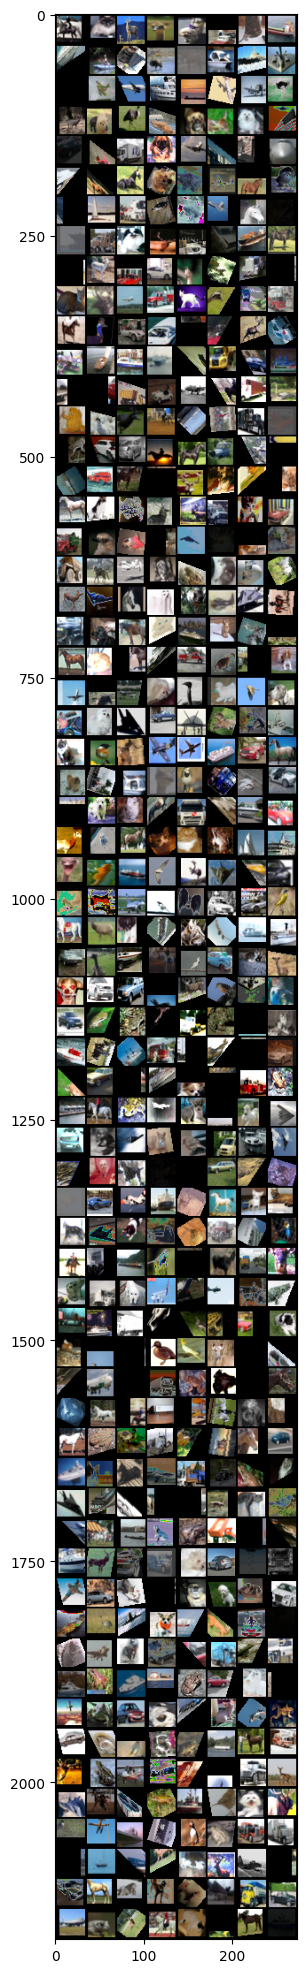

horse: 1.00 cat  : 0.95 deer : 1.00 bird : 1.00 dog  : 1.00 automobile: 0.80 cat  : 1.00 ship : 1.00 ship : 0.49 ship : 1.00 truck: 1.00 deer : 0.98 horse: 0.39 ship : 1.00 ship : 0.93 airplane: 1.00 ship : 0.10 airplane: 1.00 airplane: 0.75 ship : 1.00 ship : 1.00 airplane: 1.00 airplane: 0.99 bird : 1.00 deer : 1.00 deer : 1.00 bird : 0.98 cat  : 0.82 dog  : 1.00 deer : 0.99 dog  : 1.00 airplane: 1.00 automobile: 0.75 airplane: 0.38 truck: 1.00 dog  : 1.00 airplane: 1.00 truck: 0.35 cat  : 0.96 airplane: 1.00 truck: 0.34 horse: 0.24 horse: 1.00 dog  : 1.00 frog : 1.00 airplane: 1.00 horse: 0.80 dog  : 1.00 ship : 0.54 ship : 1.00 truck: 1.00 cat  : 1.00 frog : 1.00 airplane: 0.98 horse: 1.00 frog : 0.16 ship : 0.39 truck: 1.00 dog  : 0.98 deer : 1.00 automobile: 1.00 automobile: 0.97 ship : 1.00 horse: 0.99 airplane: 0.19 deer : 1.00 automobile: 0.80 automobile: 1.00 bird : 1.00 deer : 1.00 truck: 0.95 ship : 0.19 cat  : 1.00 deer : 0.98 airplane: 1.00 truck: 1.00 cat  : 0.99 bird : 

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.figure(figsize=(20, 25))  # Adjust the width and height as needed
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(custom_trainloader)
images, labels, confidences = next(dataiter)

# if training baseline model, uncomment this
# dataiter = iter(baseline_trainloader)
# images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

# print labels 
if isinstance(confidences, list):
    # in case we have confidence 
    confidences = confidences[1]
    print(' '.join(f'{classes[labels[j]]:5s}: {confidences[j].item():.2f}' for j in range(batch_size)))
else:
    print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import numpy as np


# Manual implementation of ResNet18
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=num_classes):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Global average pooling layer
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)  # Apply global average pooling
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out



# ResNet18 Architecture
def ResNet18(num_classes=num_classes):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)

In [7]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=True)

def conv_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.xavier_uniform(m.weight, gain=np.sqrt(2))
        init.constant(m.bias, 0)
    elif classname.find('BatchNorm') != -1:
        init.constant(m.weight, 1)
        init.constant(m.bias, 0)

class WideBasic(nn.Module):
    def __init__(self, in_planes, planes, dropout_rate, stride=1):
        super(WideBasic, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, padding=1, bias=True)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=True),
            )

    def forward(self, x):
        out = self.dropout(self.conv1(F.relu(self.bn1(x))))
        out = self.conv2(F.relu(self.bn2(out)))
        out += self.shortcut(x)

        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



class WideResNet(nn.Module):
    def __init__(self, depth, widen_factor, dropout_rate=0.3, num_classes=num_classes, factor=1, block=WideBasic):
        super(WideResNet, self).__init__()
        self.in_planes = 16

        assert ((depth-4)%6 ==0), 'Wide-resnet depth should be 6n+4'
        n = (int)((depth-4)/6)
        k = widen_factor

        nStages = [16, 16*k, 32*k, 64*k]

        self.conv1 = conv3x3(3,nStages[0], stride=1)
        self.layer1 = self._wide_layer(block, nStages[1], n, dropout_rate, stride=factor)
        self.layer2 = self._wide_layer(block, nStages[2], n, dropout_rate, stride=2)
        self.layer3 = self._wide_layer(block, nStages[3], n, dropout_rate, stride=2)
        self.bn1 = nn.BatchNorm2d(nStages[3], momentum=0.9)
        self.linear = nn.Linear(nStages[3], num_classes)

    def _wide_layer(self, block, planes, num_blocks, dropout_rate, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []

        for stride in strides:
            layers.append(block(self.in_planes, planes, dropout_rate, stride))
            self.in_planes = planes

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)

        return out

def WideResNet_28_4(num_classes, factor=1, block=WideBasic, dropout_rate=0.3):
    return WideResNet(depth=28, widen_factor=4, dropout_rate=dropout_rate, num_classes=num_classes, factor=factor, block=block)

Model Training

In [8]:
# Initialize the model
net = WideResNet_28_4(num_classes=num_classes)
net.to(device)

WideResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer1): Sequential(
    (0): WideBasic(
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout): Dropout(p=0.3, inplace=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut): Sequential(
        (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (1): WideBasic(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout): Dropout(p=0.3, inplace=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, ke

In [9]:
num_classes

10

In [10]:
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
import time

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.15, momentum=0.9, weight_decay=1e-4)

# Initialize the scheduler
epochs = 100
scheduler = CosineAnnealingLR(optimizer, T_max=epochs)  # Cosine Annealing LR Scheduler

# For plotting
train_losses, test_accuracies = [], []

# Training loop
print(f'\nStart Training...\n')
for epoch in range(epochs):  # loop over the dataset multiple times
    
    start_time = time.time()
    
    running_loss = 0.0
    total_train = 0
    correct_train = 0
    total = 0
    correct = 0
    
    net.train()
#     for i, (inputs, labels) in enumerate(baseline_trainloader):
    for i, (inputs, labels, confidences) in enumerate(custom_trainloader):
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # when the model returns [augmentation_magnitude, confidence_aa], which is the case
#         only when TA with soft labels is applied
        if isinstance(confidences, list):
            confidences = confidences[1]
            
        # get the inputs
        inputs, labels, confidences = inputs.to(device), labels.to(device), confidences.to(device)
#         inputs, labels = inputs.to(device), labels.to(device)
    
        # Convert labels to one-hot encoded vectors
#         labels_one_hot = F.one_hot(labels, num_classes=10).float()
        
        # forward + backward + optimize
        outputs = net(inputs)
#         print(f'pred: {outputs}\tlabel: {labels}\tconf: {confidences}')
#         hloss = criterion(outputs, labels)  
        loss = soft_loss(pred=outputs, label=labels, confidence=confidences)
#         print(f'Loss: {loss:.3f}\tHard Loss: {hloss:.3f}')

        loss.backward()
        optimizer.step()
        if tpu:
            xm.mark_step()
        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    with torch.no_grad():
        net.eval()
        for images, labels in baseline_testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # calculate and print average loss for current epoch
    average_loss = running_loss / len(custom_trainloader)
    train_losses.append(average_loss)
    
    test_accuracy = correct / total
    test_accuracies.append(test_accuracy)
    
    print(f'\nEpoch {epoch + 1} - Loss: {average_loss:.3f} - Test Accuracy: {100 * test_accuracy: .3f}')    
    
    scheduler.step()
    end_time = time.time()
    print(f'\nProcessing time: {(end_time - start_time): 3f} seconds.')

print('Finished Training')

# Save the trained model
PATH = f'/kaggle/working/cifar10_net_ta_soft_{epochs}.pth'
torch.save(net.state_dict(), PATH)


Start Training...



/usr/local/lib/python3.10/site-packages/torch/autograd/graph.py:768: UserWarning: aten::kl_div: an autograd kernel was not registered to the Autograd key(s) but we are trying to backprop through it. This may lead to silently incorrect behavior. This behavior is deprecated and will be removed in a future version of PyTorch. If your operator is differentiable, please ensure you have registered an autograd kernel to the correct Autograd key (e.g. DispatchKey::Autograd, DispatchKey::CompositeImplicitAutograd). If your operator is not differentiable, or to squash this warning and use the previous behavior, please register torch::CppFunction::makeFallthrough() to DispatchKey::Autograd. (Triggered internally at ../torch/csrc/autograd/autograd_not_implemented_fallback.cpp:63.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass



Epoch 1 - Loss: 1.623 - Test Accuracy:  30.410

Processing time:  71.947682 seconds.



Epoch 2 - Loss: 1.344 - Test Accuracy:  41.170

Processing time:  40.260241 seconds.



Epoch 3 - Loss: 1.167 - Test Accuracy:  40.740

Processing time:  20.998931 seconds.



Epoch 4 - Loss: 1.030 - Test Accuracy:  60.520

Processing time:  21.243298 seconds.



Epoch 5 - Loss: 0.934 - Test Accuracy:  52.520

Processing time:  20.668322 seconds.



Epoch 6 - Loss: 0.862 - Test Accuracy:  72.110

Processing time:  20.669423 seconds.



Epoch 7 - Loss: 0.792 - Test Accuracy:  55.670

Processing time:  20.820286 seconds.



Epoch 8 - Loss: 0.735 - Test Accuracy:  68.330

Processing time:  20.933749 seconds.



Epoch 9 - Loss: 0.695 - Test Accuracy:  77.500

Processing time:  21.359552 seconds.



Epoch 10 - Loss: 0.668 - Test Accuracy:  69.840

Processing time:  21.084667 seconds.



Epoch 11 - Loss: 0.636 - Test Accuracy:  80.160

Processing time:  21.290922 seconds.



Epoch 12 - Loss: 0.612 - Test Accuracy:  77.340

Processing time:  20.757785 seconds.



Epoch 13 - Loss: 0.587 - Test Accuracy:  73.180

Processing time:  20.596900 seconds.



Epoch 14 - Loss: 0.568 - Test Accuracy:  79.570

Processing time:  20.426174 seconds.



Epoch 15 - Loss: 0.543 - Test Accuracy:  79.440

Processing time:  20.471626 seconds.



Epoch 16 - Loss: 0.533 - Test Accuracy:  80.190

Processing time:  20.168917 seconds.



Epoch 17 - Loss: 0.509 - Test Accuracy:  82.840

Processing time:  20.018074 seconds.



Epoch 18 - Loss: 0.504 - Test Accuracy:  81.080

Processing time:  20.158878 seconds.



Epoch 19 - Loss: 0.491 - Test Accuracy:  82.760

Processing time:  19.915875 seconds.



Epoch 20 - Loss: 0.480 - Test Accuracy:  81.810

Processing time:  21.725582 seconds.



Epoch 21 - Loss: 0.462 - Test Accuracy:  78.880

Processing time:  20.068494 seconds.



Epoch 22 - Loss: 0.453 - Test Accuracy:  80.200

Processing time:  21.465560 seconds.



Epoch 23 - Loss: 0.443 - Test Accuracy:  77.440

Processing time:  21.029210 seconds.



Epoch 24 - Loss: 0.438 - Test Accuracy:  83.280

Processing time:  21.505445 seconds.



Epoch 25 - Loss: 0.425 - Test Accuracy:  83.890

Processing time:  20.798237 seconds.



Epoch 26 - Loss: 0.420 - Test Accuracy:  82.380

Processing time:  20.434001 seconds.



Epoch 27 - Loss: 0.410 - Test Accuracy:  87.530

Processing time:  20.836154 seconds.



Epoch 28 - Loss: 0.393 - Test Accuracy:  85.310

Processing time:  20.619512 seconds.



Epoch 29 - Loss: 0.401 - Test Accuracy:  84.420

Processing time:  20.547679 seconds.



Epoch 30 - Loss: 0.384 - Test Accuracy:  87.500

Processing time:  20.502648 seconds.



Epoch 31 - Loss: 0.379 - Test Accuracy:  88.020

Processing time:  20.623087 seconds.



Epoch 32 - Loss: 0.373 - Test Accuracy:  89.350

Processing time:  20.674207 seconds.



Epoch 33 - Loss: 0.365 - Test Accuracy:  86.520

Processing time:  20.641411 seconds.



Epoch 34 - Loss: 0.357 - Test Accuracy:  83.210

Processing time:  21.619624 seconds.



Epoch 35 - Loss: 0.356 - Test Accuracy:  89.630

Processing time:  20.733169 seconds.



Epoch 36 - Loss: 0.346 - Test Accuracy:  87.070

Processing time:  20.479706 seconds.



Epoch 37 - Loss: 0.344 - Test Accuracy:  87.260

Processing time:  20.397691 seconds.



Epoch 38 - Loss: 0.339 - Test Accuracy:  88.280

Processing time:  20.436236 seconds.



Epoch 39 - Loss: 0.328 - Test Accuracy:  87.920

Processing time:  20.700516 seconds.



Epoch 40 - Loss: 0.322 - Test Accuracy:  83.970

Processing time:  20.596618 seconds.



Epoch 41 - Loss: 0.320 - Test Accuracy:  87.730

Processing time:  20.446446 seconds.



Epoch 42 - Loss: 0.315 - Test Accuracy:  88.220

Processing time:  20.589387 seconds.



Epoch 43 - Loss: 0.303 - Test Accuracy:  87.330

Processing time:  20.395053 seconds.



Epoch 44 - Loss: 0.308 - Test Accuracy:  90.450

Processing time:  20.411318 seconds.



Epoch 45 - Loss: 0.291 - Test Accuracy:  87.490

Processing time:  20.799161 seconds.



Epoch 46 - Loss: 0.294 - Test Accuracy:  89.840

Processing time:  20.774547 seconds.



Epoch 47 - Loss: 0.292 - Test Accuracy:  90.520

Processing time:  20.472154 seconds.



Epoch 48 - Loss: 0.284 - Test Accuracy:  89.870

Processing time:  20.693038 seconds.



Epoch 49 - Loss: 0.278 - Test Accuracy:  89.510

Processing time:  20.835484 seconds.



Epoch 50 - Loss: 0.281 - Test Accuracy:  90.660

Processing time:  20.549467 seconds.



Epoch 51 - Loss: 0.269 - Test Accuracy:  89.370

Processing time:  20.999760 seconds.



Epoch 52 - Loss: 0.270 - Test Accuracy:  89.490

Processing time:  20.798239 seconds.



Epoch 53 - Loss: 0.259 - Test Accuracy:  90.760

Processing time:  20.706352 seconds.



Epoch 54 - Loss: 0.259 - Test Accuracy:  91.510

Processing time:  20.224669 seconds.



Epoch 55 - Loss: 0.257 - Test Accuracy:  91.660

Processing time:  20.293276 seconds.



Epoch 56 - Loss: 0.254 - Test Accuracy:  91.240

Processing time:  20.147196 seconds.



Epoch 57 - Loss: 0.248 - Test Accuracy:  91.920

Processing time:  20.690958 seconds.



Epoch 58 - Loss: 0.244 - Test Accuracy:  91.400

Processing time:  20.358726 seconds.



Epoch 59 - Loss: 0.237 - Test Accuracy:  91.570

Processing time:  20.176425 seconds.



Epoch 60 - Loss: 0.234 - Test Accuracy:  91.630

Processing time:  20.408575 seconds.



Epoch 61 - Loss: 0.226 - Test Accuracy:  93.300

Processing time:  20.225270 seconds.



Epoch 62 - Loss: 0.227 - Test Accuracy:  90.750

Processing time:  20.562849 seconds.



Epoch 63 - Loss: 0.221 - Test Accuracy:  92.690

Processing time:  20.437552 seconds.



Epoch 64 - Loss: 0.215 - Test Accuracy:  92.310

Processing time:  20.223000 seconds.



Epoch 65 - Loss: 0.217 - Test Accuracy:  92.390

Processing time:  20.401134 seconds.



Epoch 66 - Loss: 0.211 - Test Accuracy:  92.360

Processing time:  20.408546 seconds.



Epoch 67 - Loss: 0.209 - Test Accuracy:  92.870

Processing time:  20.726378 seconds.



Epoch 68 - Loss: 0.206 - Test Accuracy:  93.220

Processing time:  20.528296 seconds.



Epoch 69 - Loss: 0.199 - Test Accuracy:  93.060

Processing time:  20.322012 seconds.



Epoch 70 - Loss: 0.200 - Test Accuracy:  92.350

Processing time:  21.107778 seconds.



Epoch 71 - Loss: 0.196 - Test Accuracy:  93.580

Processing time:  20.367664 seconds.



Epoch 72 - Loss: 0.190 - Test Accuracy:  93.100

Processing time:  20.508240 seconds.



Epoch 73 - Loss: 0.190 - Test Accuracy:  93.230

Processing time:  20.397501 seconds.



Epoch 74 - Loss: 0.184 - Test Accuracy:  93.760

Processing time:  20.449344 seconds.



Epoch 75 - Loss: 0.186 - Test Accuracy:  93.040

Processing time:  20.417385 seconds.



Epoch 76 - Loss: 0.179 - Test Accuracy:  93.670

Processing time:  20.458920 seconds.



Epoch 77 - Loss: 0.179 - Test Accuracy:  93.700

Processing time:  20.217264 seconds.



Epoch 78 - Loss: 0.175 - Test Accuracy:  93.780

Processing time:  20.600016 seconds.



Epoch 79 - Loss: 0.173 - Test Accuracy:  94.070

Processing time:  20.332792 seconds.



Epoch 80 - Loss: 0.171 - Test Accuracy:  94.240

Processing time:  20.569290 seconds.



Epoch 81 - Loss: 0.171 - Test Accuracy:  94.230

Processing time:  20.552884 seconds.



Epoch 82 - Loss: 0.167 - Test Accuracy:  94.110

Processing time:  20.425630 seconds.



Epoch 83 - Loss: 0.165 - Test Accuracy:  94.360

Processing time:  20.668843 seconds.



Epoch 84 - Loss: 0.160 - Test Accuracy:  94.180

Processing time:  20.408910 seconds.



Epoch 85 - Loss: 0.159 - Test Accuracy:  94.250

Processing time:  20.454407 seconds.



Epoch 86 - Loss: 0.159 - Test Accuracy:  94.600

Processing time:  20.809818 seconds.



Epoch 87 - Loss: 0.157 - Test Accuracy:  94.690

Processing time:  21.062488 seconds.



Epoch 88 - Loss: 0.158 - Test Accuracy:  94.550

Processing time:  20.572552 seconds.



Epoch 89 - Loss: 0.154 - Test Accuracy:  94.600

Processing time:  20.855043 seconds.



Epoch 90 - Loss: 0.155 - Test Accuracy:  94.570

Processing time:  20.288801 seconds.



Epoch 91 - Loss: 0.152 - Test Accuracy:  94.410

Processing time:  20.279508 seconds.



Epoch 92 - Loss: 0.154 - Test Accuracy:  94.760

Processing time:  20.666075 seconds.



Epoch 93 - Loss: 0.153 - Test Accuracy:  94.670

Processing time:  20.486844 seconds.



Epoch 94 - Loss: 0.151 - Test Accuracy:  94.840

Processing time:  20.510598 seconds.



Epoch 95 - Loss: 0.151 - Test Accuracy:  94.760

Processing time:  19.948801 seconds.



Epoch 96 - Loss: 0.146 - Test Accuracy:  94.740

Processing time:  21.117493 seconds.



Epoch 97 - Loss: 0.149 - Test Accuracy:  94.730

Processing time:  20.764083 seconds.



Epoch 98 - Loss: 0.150 - Test Accuracy:  94.830

Processing time:  20.616194 seconds.



Epoch 99 - Loss: 0.149 - Test Accuracy:  94.950

Processing time:  20.586836 seconds.



Epoch 100 - Loss: 0.145 - Test Accuracy:  94.840

Processing time:  20.579621 seconds.
Finished Training


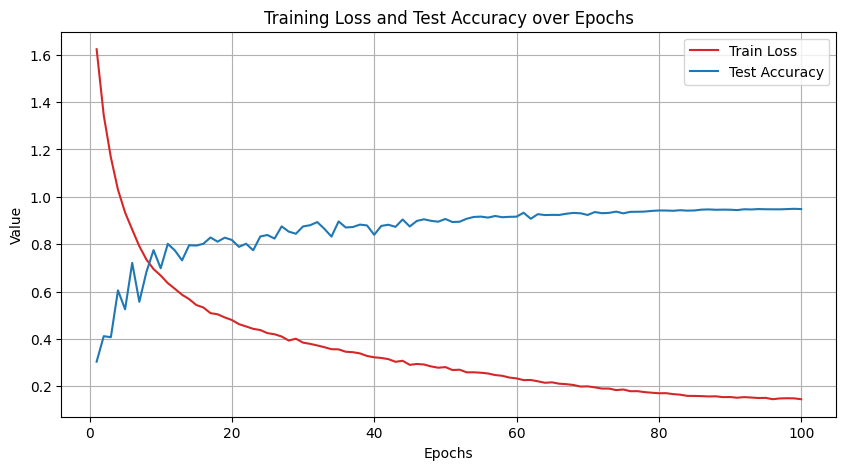

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', color='tab:red')
plt.plot(range(1, epochs + 1), test_accuracies, label='Test Accuracy', color='tab:blue')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Training Loss and Test Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Evaluate the model on Testset

In [12]:
import torch
import numpy as np

# Evaluate the CIFAR-10 dataset
correct = 0
total = 0

with torch.no_grad():
    net.eval()
    for images, labels in baseline_testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    if total == 0:
        print('No images found for CIFAR-10 dataset.')
    else:
        cifar10_accuracy = 100 * correct / total
        print(f'Accuracy of the network on the CIFAR-10 test dataset: {cifar10_accuracy:.2f} %')

# if not tpu:
#     # Clear GPU memory
#     torch.cuda.empty_cache()

#     # Clear CPU memory
#     torch.cuda.ipc_collect()

# # Define the list of corruptions
# corruptions = ['gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur', 'glass_blur', 
#                'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog', 'brightness', 
#                'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression', 
#                'speckle_noise', 'gaussian_blur', 'spatter', 'saturate']

# # Define the batch size
# batch_size = 256 

# # Create an empty dictionary to store corrupted datasets
# corrupted_datasets = {}

# # Prepare to count predictions for each class
# correct_pred = {classname: 0 for classname in classes}
# total_pred = {classname: 0 for classname in classes}

# # List to store average accuracies for each corruption dataset
# average_accuracies = []

# # Loop over corruptions, loading and testing all 5 severity levels of each corruption dataset
# for corruption in corruptions:
#     print(f"Testing on corruption: {corruption}")

#     # Load and test datasets for all 5 severity levels of the current corruption
#     try:
# #         np_data_c = np.load(f'/kaggle/input/cifar-10-c/{corruption}.npy')

#         np_data_c = np.load(f'/kaggle/input/cifar-c/CIFAR-10-C/{corruption}.npy')
#         np_data_c_splits = np.array_split(np_data_c, 5)
        
#         # List to store accuracies of all severity levels for averaging
#         accuracies = []

#         for i, np_data_c_split in enumerate(np_data_c_splits):
#             custom_dataset = CustomDataset(np_data_c_split, baseline_testset, resize=True)
#             custom_dataloader = torch.utils.data.DataLoader(custom_dataset, batch_size=batch_size, shuffle=False)

#             # Testing loop for the current corruption dataset split
#             correct = 0
#             total = 0

#             with torch.no_grad():
#                 images_loaded = 0  # Counter for images loaded for the current corruption
#                 for images, labels in custom_dataloader:
#                     images_loaded += len(images)  # Increment the counter by the number of images loaded
#                     images, labels = images.to(device), labels.to(device)
#                     # Calculate outputs by running images through the network
#                     outputs = net(images)
#                     # The class with the highest energy is chosen as prediction
#                     _, predicted = torch.max(outputs.data, 1)
#                     total += labels.size(0)
#                     correct += (predicted == labels).sum().item()

#                 if total == 0:
#                     print(f'No images found for {corruption} dataset split {i+1}.')
#                 else:
#                     accuracy = 100 * correct / total
#                     print(f'Accuracy of the network on {corruption} dataset split {i+1}: {accuracy:.2f} %')
#                     accuracies.append(accuracy)

#                 # Print the number of images loaded for the current corruption dataset split
#                 #print(f"Images loaded for {corruption} dataset split {i+1}: {images_loaded}")
                
#                 if not tpu:
#                     # Clear GPU memory
#                     torch.cuda.empty_cache()
#                     # Clear CPU memory
#                     torch.cuda.ipc_collect()

#                 # Delete variables to free up memory
#                 del custom_dataset
#                 del custom_dataloader

#         # Calculate and print the average accuracy for the corruption dataset
#         if accuracies:
#             average_accuracy = sum(accuracies) / len(accuracies)
#             average_accuracies.append(average_accuracy)
#             print(f'Average accuracy for {corruption} dataset: {average_accuracy:.2f} %')

#     except FileNotFoundError:
#         print(f'Corruption {corruption} dataset not found.')
#         continue

# # Calculate and print the average robust accuracy
# if average_accuracies:
#     average_robust_accuracy = sum(average_accuracies) / len(average_accuracies)
#     print(f'Average Robust Accuracy: {average_robust_accuracy:.2f} %')
# else:
#     print("No corrupt datasets found for evaluation.")

Accuracy of the network on the CIFAR-10 test dataset: 94.84 %
